# Analitic model for single qubit

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import qutip as qu
import random
import pickle
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm

df = pd.read_excel('09-1216A-A_DW_2000Q_6_annealing_schedule.xls', sheet_name=1)
nominal_temp_ghz = 13.5 / 47.9924341590788

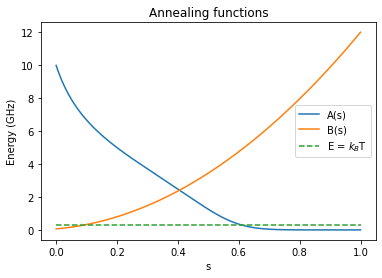

In [2]:
plt.figure()
plt.plot(df['s'], df['A(s) (GHz)'], label='A(s)')
plt.plot(df['s'], df['B(s) (GHz)'], label='B(s)')
plt.plot(np.linspace(0,1), nominal_temp_ghz * np.ones(50), linestyle='--', label='E = $k_B$T')

plt.title('Annealing functions')
plt.xlabel('s')
plt.ylabel('Energy (GHz)')
plt.legend()
plt.show()

## Last time results

In [3]:
biases_ex, spin_up_ex, dspin_up_ex = pickle.load(open("data/results.pickle", "rb"))

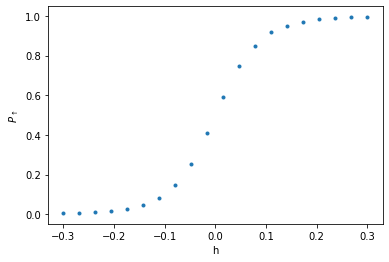

In [4]:
# grafico popolaz ground state vs h
plt.figure()
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.show()

## Solving Schroedinger eq: analitic solution at T=0

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

Considering a linear ramping of s with time (from $t_i=0$ to $t_f = 20 \mu s$)

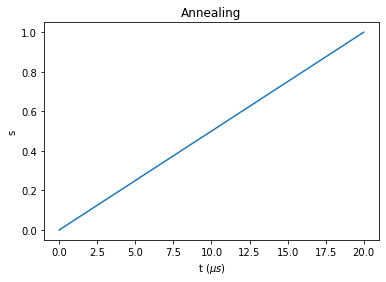

In [5]:
# linear foward anneal schedule
plt.figure()
plt.plot([0, 20], [0, 1])
plt.title('Annealing')
plt.xlabel('t ($\mu s$)')
plt.ylabel('s')
plt.show()

$$ i \hbar \frac{\partial}{\partial t} | \psi(t) \rangle = H(t) | \psi (t) \rangle $$

### Numerical integration

We can numerically solve schroedinger equation:
$$ \hat{\rho}(t+dt) = \hat{\rho}(t) - \frac{i}\hbar dt \left[H(t), \hat{\rho} (t) \right] $$

We need to choose a time interval $dt$ small such that $dt \times H(t) / \hbar << 1$.

Remebering that $H(t) / \hbar \sim 5 GHz$, we need $dt < 2 \times 10^{-10} s$

In [6]:
# evolution with schroedinger equation
def schroedinger_evolution(t, h):
    '''
    Given the time evolution 't' (np.array) and the bias 'h' (float)
    This function evolves the hamiltonian ground state according to Schroedinger equation.
    Return the final density matrix after evolution.
    '''
    # coefficients for linear annealing with time
    t = 1000 * t  # time (ns)
    
    A = scipy.interpolate.CubicSpline(t[-1] * df['s'], df['A(s) (GHz)'])
    B = scipy.interpolate.CubicSpline(t[-1] * df['s'], df['B(s) (GHz)'])

    H0 = - np.array([[0, 1], [1, 0]]) / 2  # initial hamiltonian
    H1 = - h * np.diag([1, -1]) / 2  # final hamiltonian
    
    H = lambda x: A(x) * H0 + B(x) * H1
    
    # initial state of evolution
    rho = np.array([[1, 1], [1, 1]]) / 2
    sigmax = []
    sigmaz = []
    err = 0
    img = 0
    
    def hamiltonian_term(ham, p):
        return ham @ p - p @ ham
    
    # perform evolution
    dt = t[1] - t[0]
    for x in t:        
        # 4th order Runge-Kutta
        k1 = - 1j * dt * hamiltonian_term(H(x), rho)
        k2 = - 1j * dt * hamiltonian_term(H(x + dt / 2), rho + k1 / 2)
        k3 = - 1j * dt * hamiltonian_term(H(x + dt / 2), rho + k2 / 2)
        k4 = - 1j * dt * hamiltonian_term(H(x + dt), rho + k3)

        # update rho
        rho = rho + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
        
        # save expectation value of operators
        sigmax.append(rho[0][1] + rho[1][0])
        sigmaz.append(rho[0][0] - rho[1][1])
        
        # check normalization
        err += abs(1 - np.trace(rho)) ** 2
        img += np.imag(sigmax[-1]) ** 2 + np.imag(sigmaz[-1]) ** 2
    
    # converting expectation values to array
    sigmaz = np.array(sigmaz)
    sigmax = np.array(sigmax)
    
    # check consitency
    assert(err < 0.01)
    assert(not any(np.iscomplex(sigmax)))
    assert(not any(np.iscomplex(sigmaz)))  
    
    return np.real(sigmaz), np.real(sigmax)

In [7]:
t = np.linspace(0, 2, 10 ** 4 + 1)
print(f'dt: {(t[1] - t[0]) / 10 ** 6} s')
sigmax, sigmaz = schroedinger_evolution(t, 0.3)

dt: 2e-10 s


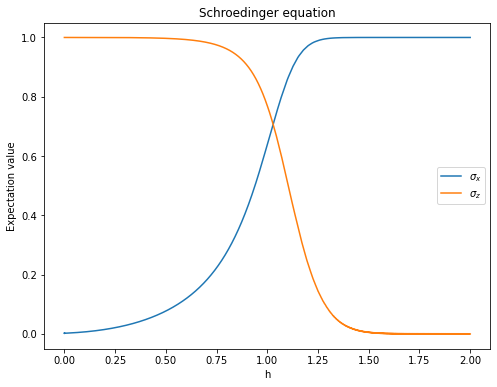

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(t, sigmax, label='$\sigma_x$')
plt.plot(t, sigmaz, label='$\sigma_z$')

plt.title('Schroedinger equation')
plt.xlabel('h')
plt.ylabel(r'Expectation value')
plt.legend()
plt.show()

In [9]:
# perform schroedinger evolution for t_final = 20 mu s
t = np.linspace(0, 20, 10 ** 5 + 1)

biases_teo = np.logspace(-4, -0.5, 8)
biases_teo = sorted(np.concatenate((- biases_teo, biases_teo)))

# performing numerical calculation
p_up = []
for h in tqdm(biases_teo):
    sigmaz, sigmax = schroedinger_evolution(t, h)
    p_up.append(sigmaz[-1] / 2 + 0.5)

# save results on file
pickle.dump((biases_teo, p_up), open(f"data/schroedinger{str(t[-1])}.pickle", "wb"))

100%|██████████| 16/16 [03:57<00:00, 14.85s/it]


In [10]:
# perform schroedinger evolution for t_final = 0.03 mu s
t = np.linspace(0, 0.03, 10 ** 2 + 1) # mu s

biases_teo = np.linspace(-0.3, 0.3, 100)  # GHz

# performing numerical calculation
p_up = []
for h in tqdm(biases_teo):
    sigmaz, sigmax = schroedinger_evolution(t, h)
    p_up.append(sigmaz[-1] / 2 + 0.5)

# save results on file
pickle.dump((biases_teo, p_up), open(f"data/schroedinger{str(t[-1])}.pickle", "wb"))

100%|██████████| 100/100 [00:01<00:00, 58.94it/s]


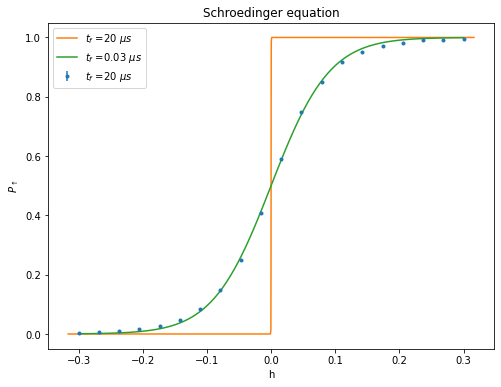

In [11]:
# opening saved data
biases_teo0, spin_up_teo0 = pickle.load(open("data/schroedinger20.0.pickle", "rb"))
biases_teo1, spin_up_teo1 = pickle.load(open("data/schroedinger0.03.pickle", "rb"))

# grafico popolaz ground state vs h, experiment and theory
plt.figure(figsize=(8, 6))
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='', label='$t_f$ =20 $\mu s$')
plt.plot(biases_teo0, spin_up_teo0, label='$t_f$ =20 $\mu s$')
plt.plot(biases_teo1, spin_up_teo1, label='$t_f$ =0.03 $\mu s$')

plt.title('Schroedinger equation')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

### QuTiP Toolkit

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

In [12]:
# evolution with schroedinger equation
def schroed_evolution(t_f, h):
    
    # coefficients for linear annealing with time
    t = t_f * 1000 * df['s'].to_numpy()  # time (ns)

    S0 = qu.Cubic_Spline(t[0], t[-1], df['A(s) (GHz)'])
    S1 = qu.Cubic_Spline(t[0], t[-1], df['B(s) (GHz)'])
    
    # initial state of evolution
    psi0 = (qu.basis(2, 0) + qu.basis(2, 1)).unit()

    H0 = - qu.sigmax() / 2  # initial hamiltonian
    H1 = - h * qu.sigmaz() / 2  # final hamiltonian
    H = [[H0, S0], [H1, S1]]
    
    # actual evolution
    result = qu.sesolve(H, psi0, t, [qu.sigmaz()])
    
    return result

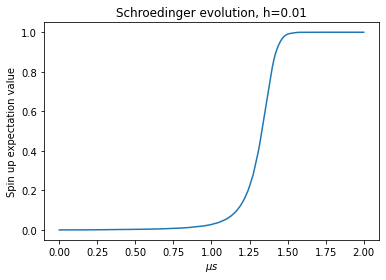

In [13]:
# plotting spin up expectation value during evolution
h = 0.01
result = schroed_evolution(2, h)

plt.figure()
plt.plot(result.times / 1000, result.expect[0])

plt.title(f'Schroedinger evolution, h={h}')
plt.xlabel('$\mu s$')
plt.ylabel('Spin up expectation value')
plt.show()

In [14]:
# perform schroedinger evolution for t_final = 20 mu s
t_final = 20  # mu s

biases_q = np.logspace(-4, -0.5, 8)
biases_q = sorted(np.concatenate((- biases_q, biases_q)))

# performing numerical calculation
p_up = [(schroed_evolution(t_final, h).expect[0][-1] + 1) / 2 for h in biases_q]

# save results on file
pickle.dump((biases_q, p_up), open(f"data/qu_schroedinger{str(t_final)}.pickle", "wb"))

In [15]:
# perform schroedinger evolution for t_final = 0.03 mu s
t_final = 0.03  # mu s

biases_q = np.linspace(-0.3, 0.3, 100)  # GHz

# performing numerical calculation
p_up = [(schroed_evolution(t_final, h).expect[0][-1] + 1) / 2 for h in biases_q]

# save results on file
pickle.dump((biases_q, p_up), open(f"data/qu_schroedinger{str(t_final)}.pickle", "wb"))

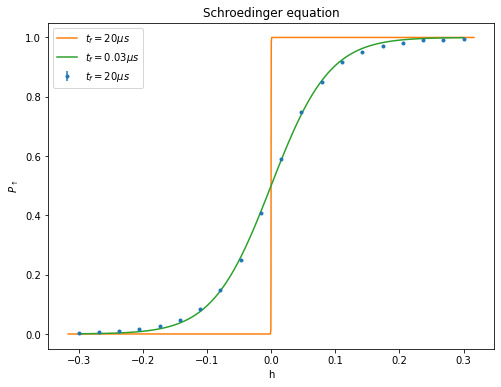

In [16]:
# opening saved data
biases_teo0, spin_up_teo0 = pickle.load(open("data/qu_schroedinger20.pickle", "rb"))
biases_teo1, spin_up_teo1 = pickle.load(open("data/qu_schroedinger0.03.pickle", "rb"))

# grafico popolaz ground state vs h, experiment and theory
plt.figure(figsize=(8, 6))
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='', label='$t_f = 20 \mu s$')
plt.plot(biases_teo0, spin_up_teo0, label='$t_f = 20 \mu s$')
plt.plot(biases_teo1, spin_up_teo1, label='$t_f = 0.03 \mu s$')

plt.title('Schroedinger equation')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

## Lindbladian: considering thermal noise

$$ \dot{\rho} = -i \left[ \mathcal{H}, \rho \right] + \sum_k \left( L_k \rho L_k ^ \dagger - \frac{1}{2} L_k^\dagger L_k \rho - \frac{1}{2} \rho L_k^\dagger L_k \right) $$

With $ \{ L_k \}_{k=1}^{d^2-1} $ Linblad operators, traceless ortoghonal basis.

### Microscopic model

We can think at the qubit S, with hamiltonian $H_S$, coupled with the environment E with hamiltonian $H_E$, initialized in the Gibbs state $\rho_E=\exp(-\beta H_E) / \mathcal{Z}_E $, through the interaction hamiltonian $H_I$.

$$ H_{S} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z, \qquad H_E = \sum_{k=1}^\infty \omega_k b_k^\dagger b_k, \qquad
H_I = \sigma^z \otimes \left[ \sum_k g_k^i \left( b_k^\dagger + b_k \right) \right] $$

Where $b_k^\dagger$ and $b_k$ are the rising and lowering operator of the oscillator with frequency $\omega_k$, and $g_k$ is the coupling constant of such mode to the system S.

The Lindblad master equation takes the form:
$$ \dot{\rho}(t) = -i[H_s(t), \rho(t)] + \gamma(\omega_{ge}(t)) \left( L_{eg}(t) \rho(t) L_{eg} ^ \dagger(t) - \frac{1}{2} L_{eg}^\dagger (t) L_{eg} (t) \rho (t) - \frac{1}{2} \rho (t) L_{eg}^\dagger (t) L_{eg} (t) \right)  + \gamma(\omega_{eg}(t)) \left( L_{ge}(t) \rho(t) L_{ge} ^ \dagger(t) - \frac{1}{2} L_{ge}^\dagger (t) L_{ge} (t) \rho (t) - \frac{1}{2} \rho (t) L_{ge}^\dagger (t) L_{ge} (t) \right) $$
plus terms $\rightarrow 0$ in the adiabatic limit.

In this model, the Lindblad operator $L_k$ are $L_{eg}$ and $L_{ge}$ (respectively the raising and lowering operators), $L_{ab}=L_{a \leftarrow b}$:
$$\newcommand{\ket}[1]{|#1\rangle}
\newcommand{\bra}[1]{\langle#1|}$$
$$ L_{ab} = \ket{\epsilon_a(t)}\bra{\epsilon_a(t)} \sigma^z \ket{\epsilon_b(t)}\bra{\epsilon_b(t)} $$

The frequency $\omega_{ab}$ is defined:
$$\omega_{ba} = \epsilon_b - \epsilon_a $$

Given the environment state,

$$ \gamma(\omega) = \frac{2 \pi J(|\omega|)}{1-\exp(-\beta|\omega|)}g_{|\omega|}^2 \left( \Theta(\omega) + e^{-\beta |\omega|} \Theta(-\omega) \right) $$

Where $J(\omega)$ is an Ohmic bath spectral function with cutoff frequency $\omega_c$
$$ J(\omega)=\eta \omega \exp(-\omega / \omega_c), \qquad [\eta]=s^2 $$

### Numerical integration

In [111]:
# function to evolve rho
omega_c = 100 * 8 * np.pi
beta = 1 / nominal_temp_ghz
g2 = 0.4 / (2 * np.pi)


def hamiltonian_term(ham, p):
    return ham @ p - p @ ham


def dissipator_term(L, p):
    L_dag = L.conj().T
    L2 = L_dag @ L
    return L @ p @ L_dag - p @ L2 / 2 - L2 @ p / 2


def liovillian(ham, p):
    # hamiltonian eigenvals and eigenvects
    eigenvalues, eigenvectors = np.linalg.eigh(ham)
    omega = eigenvalues[1] - eigenvalues[0]
    assert omega >= 0

    # Lindblad rates
    gammap = 2 * np.pi * omega * np.exp(- omega / omega_c) / (1 - np.exp(-beta*omega)) * g2
    gammam = gammap * np.exp(-beta * omega)
    
    # Lindblad operators
    a = eigenvectors[:, 0]
    b = eigenvectors[:, 1]
    a_sigmaz_b = a.conj() @ np.diag([1, -1]) @ b
    Lab = a_sigmaz_b * np.outer(a, b)
    Lba = a_sigmaz_b * np.outer(b, a)
    
    # computing p_new
    p_new = -1j * hamiltonian_term(ham, p)
    p_new += gammap * dissipator_term(Lab, p)
    p_new += gammam * dissipator_term(Lba, p)
    
    # print(gammap, gammam, a_sigmaz_b)
    # print(omega)
    
    return p_new

In [112]:
# evolution with lindblad_evolution master equation
def lindblad_evolution(t, h):
    '''
    Given the time evolution 't' (np.array) and the bias 'h' (float)
    This function evolves the hamiltonian ground state according to Lindblad master equation.
    Return the final density matrix after evolution.
    '''
    # coefficients for linear annealing with time
    t = 1000 * t  # time (ns)
    
    A = scipy.interpolate.CubicSpline(t[-1] * df['s'], df['A(s) (GHz)'])
    B = scipy.interpolate.CubicSpline(t[-1] * df['s'], df['B(s) (GHz)'])
    
    # hamiltonian
    H0 = - np.array([[0, 1], [1, 0]]) / 2  # initial hamiltonian
    H1 = - h * np.diag([1, -1]) / 2  # final hamiltonian
    
    H = lambda x: A(x) * H0 + B(x) * H1
    
    # initial state of evolution
    rho = np.array([[1, 1], [1, 1]]) / 2
    
    # results
    sigmax = []
    sigmaz = []
    err = 0
    img = 0
    
    # perform evolution
    dt = t[1] - t[0]
    
    for x in t:
        # 4th order Runge-Kutta
        k1 = dt * liovillian(H(x), rho)
        k2 = dt * liovillian(H(x + dt / 2), rho + k1 / 2)
        k3 = dt * liovillian(H(x + dt / 2), rho + k2 / 2)
        k4 = dt * liovillian(H(x + dt), rho + k3)

        # update rho
        rho = rho + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
        
        # save expectation value of operators
        sigmax.append(rho[0][1] + rho[1][0])
        sigmaz.append(rho[0][0] - rho[1][1])
        
        # check runge kutta errors (normalization and hermitianity)
        err += abs(1 - np.trace(rho)) ** 2
        img += np.imag(sigmax[-1]) ** 2 + np.imag(sigmaz[-1]) ** 2
        
    # converting expectation values to array
    sigmaz = np.array(sigmaz)
    sigmax = np.array(sigmax)
    
    # check consitency
    assert(err < 1e-10)
    assert(img < 1e-10) 
    
    # print('Errori:', err, img)
    
    return np.real(sigmaz), np.real(sigmax)

In [113]:
t = np.linspace(0, 20, 10 ** 5 + 1)
h = 0.05

print(f'dt: {(t[1] - t[0]) / 10 ** 6} s')
xs, zs = schroedinger_evolution(t, h)
sigmaz, sigmax = lindblad_evolution(t, h)

dt: 2e-10 s


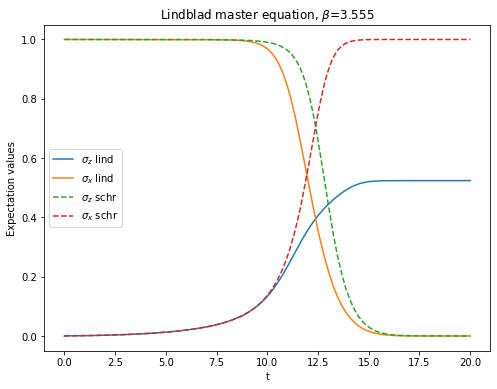

In [114]:
plt.figure(figsize=(8, 6))
plt.plot(t, sigmaz, label='$\sigma_z$ lind')
plt.plot(t, sigmax, label='$\sigma_x$ lind')

plt.plot(t, zs, ls='--', label='$\sigma_z$ schr')
plt.plot(t, xs, ls='--', label='$\sigma_x$ schr')

plt.title(fr'Lindblad master equation, $\beta$={beta:.3f}')
plt.xlabel('t')
plt.ylabel('Expectation values')
plt.legend()
plt.show()

### Various h Lindblad evolution

In [126]:
# perform schroedinger evolution for t_final = 20 mu s
temperatures = np.linspace(12, 13, 11)  # mK

for temp in tqdm(temperatures):
    t = np.linspace(0, 20, 10 ** 5 + 1)

    beta = 47.9924341590788 / temp  # 1 / GHz
    
    biases_q = np.linspace(-0.3, 0.3, 50)
    p_up = []

    # performing numerical calculation
    for h in tqdm(biases_q):
        sigmaz, sigmax = lindblad_evolution(t, h)
        p_up.append(sigmaz[-1] / 2 + 0.5)

    # save results on file
    pickle.dump((biases_q, p_up), open(f"data/qu_lindblad_various_h{temp}.pickle", "wb"))

100%|██████████| 3/3 [15:35<00:00, 311.68s/it]


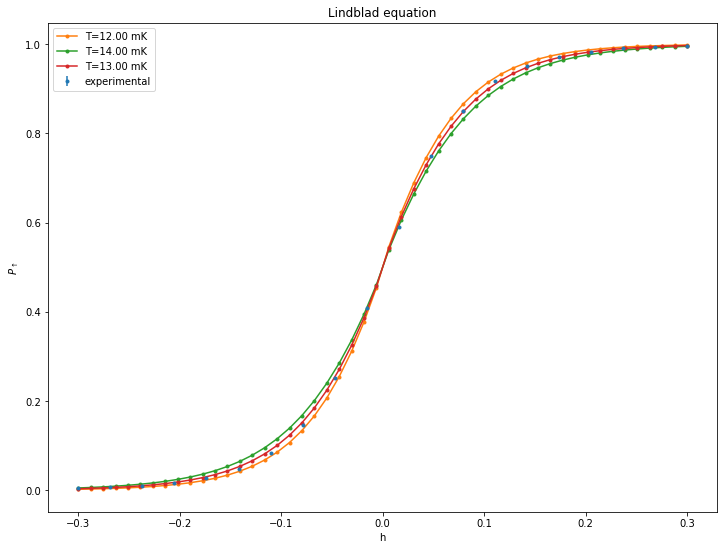

In [127]:
# grafico popolaz ground state vs h, experiment and theory
plt.figure(figsize=(12, 9))
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='', label='experimental')

# opening saved data
import glob

for f in glob.glob("data/qu_lindblad_various_h*.pickle"):
    h, p = pickle.load(open(f, "rb"))
    temp = float(f[26:-7])
    plt.plot(h, p,  marker='.', label=f'T={temp:.2f} mK')

plt.title('Lindblad equation')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

## Resonance

In [349]:
# cerco quali device sono disponibili al momento
from dwave.cloud import Client

with Client.from_config() as client:
    for solver in client.get_solvers():
        print(solver.id)

Advantage_system1.1
hybrid_binary_quadratic_model_version2
hybrid_discrete_quadratic_model_version1
DW_2000Q_6


In [354]:
# scelgo il device e mi assicuro di poterci comunicare, stampo a schermo alcune caratteristiche
from dwave.system import DWaveSampler
import dwave.inspector

sampler = DWaveSampler(solver='DW_2000Q_6')

print(f'Maximum anneal-schedule points: {sampler.properties["max_anneal_schedule_points"]}')
print(f'Annealing time range: {sampler.properties["annealing_time_range"]} \u03BCs')
print(f'Maximum slope allowed on this solver is {1.0/sampler.properties["annealing_time_range"][0]}')

# sampler.properties

Maximum anneal-schedule points: 12
Annealing time range: [1, 2000] μs
Maximum slope allowed on this solver is 1.0


In [ ]:
# parametri
annealing_time = 2000
h1 = 0.01
# per h = 0.028, il gap di l'energia lungo z fra il ground e il primo ecc dovrebbe essere pari all'energia termica

trivial_reverse_schedule = [[0.0, 1.0], [annealing_time, 1.0]]
linear_offsets = {active_node: h1 * random.choice([-1, 1]) for active_node in sampler.nodelist}
initial_state = {active_node: np.sign(linear_offsets[active_node]) for active_node in linear_offsets}

In [ ]:
# RUN 'thermal' evolution of excited sigma_z eigenstate

sampler.validate_anneal_schedule(trivial_reverse_schedule)
# sampleset = sampler.sample_ising(linear_offsets, {}, num_reads=10, auto_scale=False, anneal_schedule=trivial_reverse_schedule, initial_state=initial_state, label=f'Trivial reverse annealing test h={h}')

# save data to file
# pickle.dump((linear_offsets, sampleset), open("resonance.pickle", "wb"))

In [ ]:
linear_offsets, sampleset = pickle.load(open("resonance.pickle", "rb"))
sampleset.aggregate().to_pandas_dataframe()

In [ ]:
# richiamo alcuni parametri della simulazione
num_qubits_per_run = len(sampleset.record["sample"][0])
final_B = df['B(s) (GHz)'].to_numpy()[-1]
anneling_times = np.array(trivial_reverse_schedule).T[0]

# definisco l'energia iniziale a cui ho inizializzato lo stato e l'energia finale dopo l'evol temporale (GHz)
initial_energy = final_B * h1
final_energy = final_B * np.sum(sampleset.record['energy'] * sampleset.record['num_occurrences']) / np.sum(sampleset.record['num_occurrences']) / num_qubits_per_run

print(f'Initial state energy for {num_qubits_per_run} qubits: {h1 * num_qubits_per_run:.2f}')

In [ ]:
# plotto l'evoluzione dello stato
plt.figure(figsize=(8, 6))
plt.scatter(anneling_times, np.array([initial_energy, final_energy]), label='My state')
plt.plot(anneling_times, np.array([-initial_energy, -initial_energy]), linestyle='--', color='C1', label='Ground State')
plt.plot(anneling_times, np.array([-initial_energy + nominal_temp_ghz, -initial_energy + nominal_temp_ghz]), linestyle='--', color='C2', label='Expected asintotic state with nominal termal fluctuations')

plt.title('Trivial reverse annealing')
plt.xlabel('time ($\mu s$)')
plt.ylabel(f'Energy of 1 qubit (GHz)')
plt.legend()
plt.show()

# Entanglement

$$ \mathcal{H}_{\text{2 qubits}} = - \frac{A(s)}{2} \left[ \hat{\sigma}_x^A \otimes \mathbb{I}^B + \mathbb{I}^A \otimes \hat{\sigma}_x^B \right] + \frac{B(s)}{2} \left[ h_A \hat{\sigma}_z^A \otimes \mathbb{I}^B + h_B \mathbb{I}^A \otimes \hat{\sigma}_z^B + J \hat{\sigma}_z^A \otimes \hat{\sigma}_z^B \right] $$

In [338]:
# Voglio calcolare l'entanglement dello stato al variare di s
J = 1
h = [0.2, 0]
t_f = 2
num_time_divisions = 1000

In [339]:
# hamiltonian coefficients for linear annealing with time
t = np.linspace(0, 1000 * t_f, num_time_divisions)

# annealing parameters
S0 = qu.Cubic_Spline(t[0], t[-1], df['A(s) (GHz)'])
S1 = qu.Cubic_Spline(t[0], t[-1], df['B(s) (GHz)'])

# initial hamiltonian
H0 = -qu.tensor(qu.sigmax(), qu.identity(2)) / 2   
H0 -= qu.tensor(qu.identity(2), qu.sigmax()) / 2

# final hamiltonian
H1 = J * qu.tensor(qu.sigmaz(), qu.sigmaz()) / 2
H1 += h[0] * qu.tensor(qu.sigmaz(), qu.identity(2)) / 2
H1 += h[1] * qu.tensor(qu.identity(2), qu.sigmaz()) / 2

H = [[H0, S0], [H1, S1]]

psi_1qu = (qu.basis(2, 0) + qu.basis(2, 1)).unit()
psi0 = qu.tensor(psi_1qu, psi_1qu)

Schroendinger evolution: $h$ greater that thermal noise to avoid simulation with me

Max concurrence: 0.5210859518021973
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.03970216+0.25825896j]
 [0.06387678+0.41309478j]
 [0.11994927+0.8056315j ]
 [0.04604417+0.30240454j]]


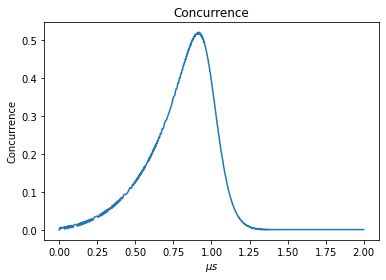

In [348]:
result = qu.sesolve(H, psi0, t, [])
entang = [qu.concurrence(result.states[i]) for i in range(len(result.times))]

max_entag_state = result.states[entang.index(max(entang))]

print('Max concurrence:', qu.concurrence(max_entag_state))
print(max_entag_state)

plt.figure()
plt.plot(result.times / 1000, entang)

plt.title(f'Concurrence')
plt.xlabel('$\mu s$')
plt.ylabel('Concurrence')
plt.show()

## Change h mid anneal

https://docs.dwavesys.com/docs/latest/c_solver_1.html#h-gain-schedule

$$ \mathcal{H}_{\text{ising}} = - \frac{A(s)}{2} \left( \sum_i \hat{\sigma}_x^{(i)} \right) + \frac{B(s)}{2} \left( g(t) \sum_i h_i \hat{\sigma}_z^{(i)} + \sum_{i>j} J_{i,j} \hat{\sigma}_z^{(i)} \hat{\sigma}_z^{(j)} \right) $$

- Controllo 'linearmente' attraverso 20 pti.
- Massimo range: [-5, 5]
- Altri vicoli.

# TODO:
- mini report venturelli
- same measure